# JAX-Fluids: Laminar channel flow

This notebook demonstrates how to run a laminar channel flow or plane poiseuille flow. This flow is created between two infinitely long parallel plates driven by a forcing. The forcing is computed by a PI controller, where the process variable is the mass flow rate. The steady state velocity profile is compared to the analytical solution. 

First we import the necessary packages

In [11]:
import matplotlib.pyplot as plt
from jaxfluids import InputReader, Initializer, SimulationManager
from jaxfluids.post_process import load_data

The file *channelflow.json* specifies a 2D flow with viscous walls and periodic boundary condition for inlet and outlet. The *numerical_setup.json* file shows:
- Inactive convective fluxes. Only the viscous terms are needed to accuretly simulate this case.
- Active mass flow forcing. We drive the fluid using a homogenous forcing that is controlling the mass flow rate.
- Active temperature forcing. Due to viscous heating, the temperature will change. We use a forcing to keep the temperature constant.

In [12]:
# SETUP 
input_reader = InputReader("channelflow.json", "numerical_setup.json")
initializer  = Initializer(input_reader)
sim_manager  = SimulationManager(input_reader)


In [ ]:
# RUN SIMULATION
buffer_dictionary = initializer.initialization()
sim_manager.simulate(buffer_dictionary)

## Plot
We plot the steady state solution for the density, velocity and pressure profile. We compare the results to the analyical solution. For our domain $y \in [0,1]$, the solution is given by 
$$u(y) = {6Q \over h^3} y(h-y) $$
where
$$Q= {\dot m \over \rho}$$
As mentioned previously, we impose a forcing that controls the mass flow rate $\dot m$. The mass flow target $\dot m=0.05$ is specified in *channelflow.json*.

The results show a constant density, which is expected as we are not solving convective terms (only viscous terms are active). The pressure is in the range $1e-7$ and increases towards the walls. This is due to viscous heating. Note that we are using a temperature forcing, that keeps the temperature (therefore pressure) constant at 1.0. This explains the small value range of the pressure. The velocity profile matches the analyitcal solution perfectly.

Loading time snapshot 2.6001e+00


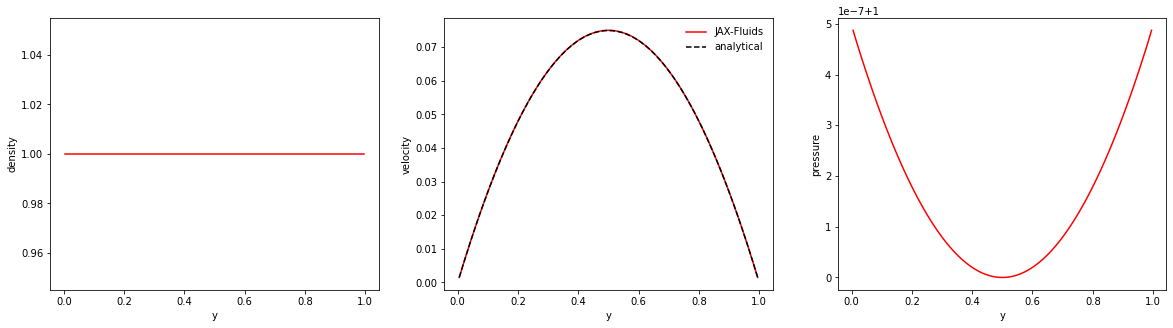

In [10]:
# LOAD DATA
path = "./results/channelflow/domain"
quantities = ["density", "velocityX", "pressure"]
cell_centers, cell_sizes, times, data_dict = load_data(path, quantities, start=-1)

# PLOT
def poiseuille_analytical(y, dm, rho, h):
    return 6 * dm / rho / h**3 * y * (h - y)

exact_solution = poiseuille_analytical(
    cell_centers[1], 
    dm = input_reader.mass_flow_target, 
    rho = input_reader.initial_condition["rho"], 
    h = input_reader.domain_size["y"][1] - input_reader.domain_size["y"][0])

fig, ax = plt.subplots(ncols=3)
fig.set_size_inches([20,5])
ax[0].plot(cell_centers[1], data_dict["density"][-1,0,:,0], color="red")
ax[1].plot(cell_centers[1], data_dict["velocityX"][-1,0,:,0], color="red", label="JAX-Fluids")
ax[1].plot(cell_centers[1], exact_solution, color="black", linestyle="--", label="analytical")
ax[2].plot(cell_centers[1], data_dict["pressure"][-1,0,:,0], color="red")
ax[0].set_xlabel("y")
ax[1].set_xlabel("y")
ax[2].set_xlabel("y")
ax[0].set_ylabel("density")
ax[1].set_ylabel("velocity")
ax[2].set_ylabel("pressure")
ax[1].legend(frameon=False)
plt.show()